In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/league-of-legends-diamond-ranked-games-10-min/high_diamond_ranked_10min.csv


In [2]:
hdr10 = pd.read_csv(os.path.join(dirname, filename))

In [3]:
hdr10.columns = hdr10.columns.str.lower()
hdr10.head()

,gameid,bluewins,bluewardsplaced,bluewardsdestroyed,bluefirstblood,bluekills,bluedeaths,blueassists,blueelitemonsters,bluedragons,...,redtowersdestroyed,redtotalgold,redavglevel,redtotalexperience,redtotalminionskilled,redtotaljungleminionskilled,redgolddiff,redexperiencediff,redcspermin,redgoldpermin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [4]:
hdr10.set_index('gameid',inplace=True)

## EDA

In [5]:
hdr10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9879 entries, 4519157822 to 4523772935
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bluewins                      9879 non-null   int64  
 1   bluewardsplaced               9879 non-null   int64  
 2   bluewardsdestroyed            9879 non-null   int64  
 3   bluefirstblood                9879 non-null   int64  
 4   bluekills                     9879 non-null   int64  
 5   bluedeaths                    9879 non-null   int64  
 6   blueassists                   9879 non-null   int64  
 7   blueelitemonsters             9879 non-null   int64  
 8   bluedragons                   9879 non-null   int64  
 9   blueheralds                   9879 non-null   int64  
 10  bluetowersdestroyed           9879 non-null   int64  
 11  bluetotalgold                 9879 non-null   int64  
 12  blueavglevel                  9879 non-null   f

In [6]:
hdr10.bluewins.value_counts()

0    4949
1    4930
Name: bluewins, dtype: int64

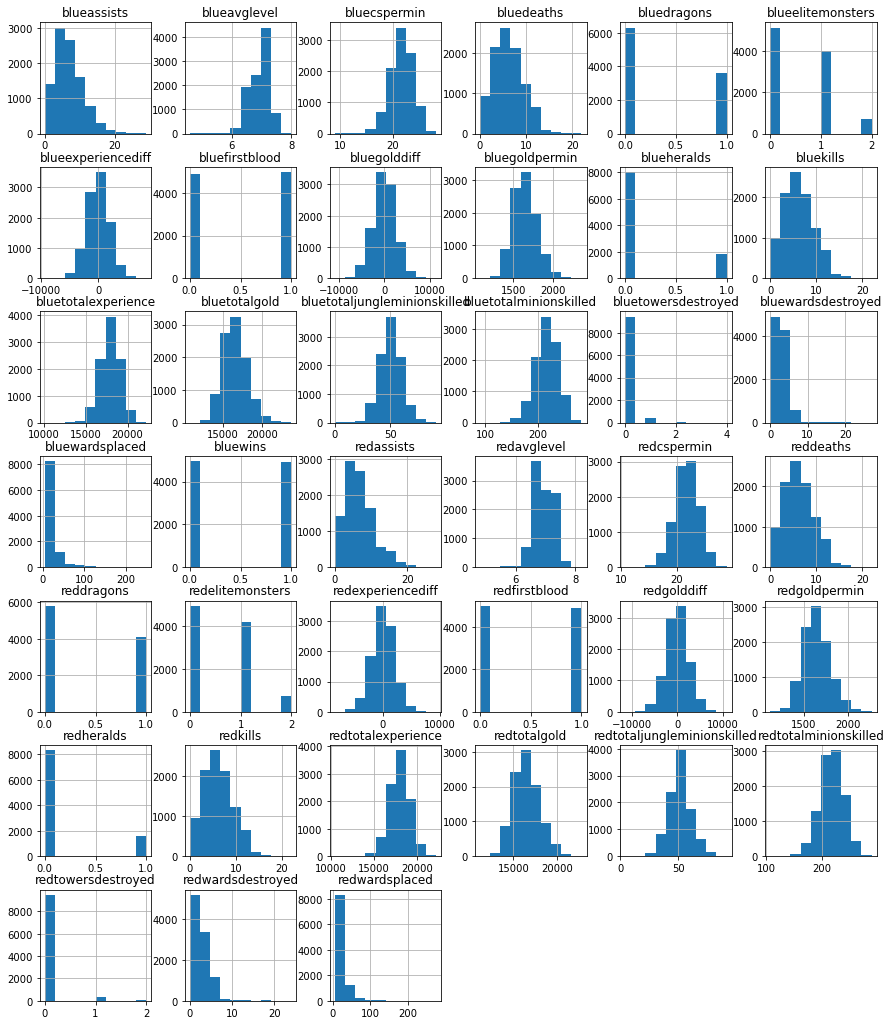

In [7]:
#plt.figure(figsize=[15,15])
hdr10.hist(figsize=[15,18]);
#plt.show()

In [8]:
hdr10.columns

Index(['bluewins', 'bluewardsplaced', 'bluewardsdestroyed', 'bluefirstblood',
       'bluekills', 'bluedeaths', 'blueassists', 'blueelitemonsters',
       'bluedragons', 'blueheralds', 'bluetowersdestroyed', 'bluetotalgold',
       'blueavglevel', 'bluetotalexperience', 'bluetotalminionskilled',
       'bluetotaljungleminionskilled', 'bluegolddiff', 'blueexperiencediff',
       'bluecspermin', 'bluegoldpermin', 'redwardsplaced', 'redwardsdestroyed',
       'redfirstblood', 'redkills', 'reddeaths', 'redassists',
       'redelitemonsters', 'reddragons', 'redheralds', 'redtowersdestroyed',
       'redtotalgold', 'redavglevel', 'redtotalexperience',
       'redtotalminionskilled', 'redtotaljungleminionskilled', 'redgolddiff',
       'redexperiencediff', 'redcspermin', 'redgoldpermin'],
      dtype='object')

In [9]:
hdr10['minionskilldifference'] = hdr10["bluetotalminionskilled"]-hdr10["redtotalminionskilled"]

In [10]:
minionkillpositive_temp = hdr10.query("minionskilldifference>0")['bluewins']
minionkillpositive_pie = minionkillpositive_temp.value_counts()

In [11]:
minionkillpositive_pie.rename(index={1: "Won", 0:"Lost"}, inplace=True)

In [12]:
minionkillnegative_temp = hdr10.query("minionskilldifference<=0")['bluewins']
minionkillnegative_pie = minionkillnegative_temp.value_counts()

In [13]:
minionkillnegative_pie.rename(index={1: "Won", 0:"Lost"}, inplace=True)
minionkillnegative_pie

Lost    3180
Won     1922
Name: bluewins, dtype: int64

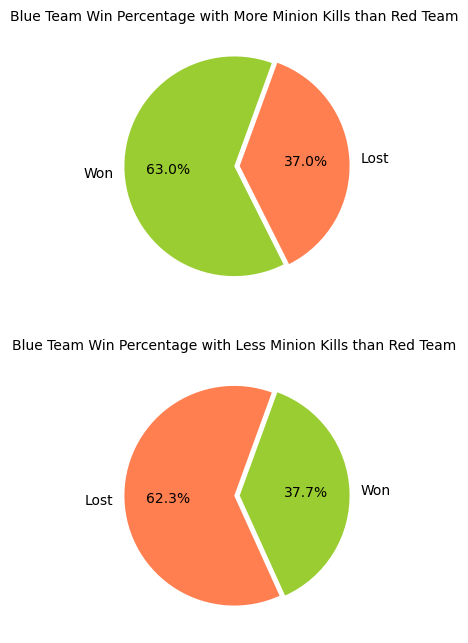

In [14]:
fig = plt.figure(figsize=(10,8), dpi=100)
ax1 = plt.subplot2grid((2,1),(0,0))
plt.pie(minionkillpositive_pie, labels=minionkillpositive_pie.index, explode= (0,0.05),
       colors=['YellowGreen', 'Coral'],
       autopct='%1.1f%%', startangle=70)
plt.title("Blue Team Win Percentage with More Minion Kills than Red Team", fontsize=10, color='Black')

ax1 = plt.subplot2grid((2,1),(1,0))
plt.pie(minionkillnegative_pie, labels=minionkillnegative_pie.index, explode= (0,0.05),
       colors=['Coral', 'Yellowgreen'],
       autopct='%1.1f%%', startangle=70)
plt.title("Blue Team Win Percentage with Less Minion Kills than Red Team", fontsize=10, color='Black');

In [15]:
hdr10.head()

,bluewins,bluewardsplaced,bluewardsdestroyed,bluefirstblood,bluekills,bluedeaths,blueassists,blueelitemonsters,bluedragons,blueheralds,...,redtotalgold,redavglevel,redtotalexperience,redtotalminionskilled,redtotaljungleminionskilled,redgolddiff,redexperiencediff,redcspermin,redgoldpermin,minionskilldifference
gameid,,,,,,,,,,,,,,,,,,,,,
4519157822,0,28,2,1,9,6,11,0,0,0,...,16567,6.8,17047,197,55,-643,8,19.7,1656.7,-2
4523371949,0,12,1,0,5,5,5,0,0,0,...,17620,6.8,17438,240,52,2908,1173,24.0,1762.0,-66
4521474530,0,15,0,0,7,11,4,1,1,0,...,17285,6.8,17254,203,28,1172,1033,20.3,1728.5,-17
4524384067,0,43,1,0,4,5,5,1,0,1,...,16478,7.0,17961,235,47,1321,7,23.5,1647.8,-34
4436033771,0,75,4,0,6,6,6,0,0,0,...,17404,7.0,18313,225,67,1004,-230,22.5,1740.4,-15


In [16]:
#kills difference
hdr10["championkilldifference"] = hdr10["bluekills"] - hdr10["redkills"]

In [17]:
champkillpositive_temp = hdr10.query("championkilldifference>0")['bluewins']
champkillpositive_pie = champkillpositive_temp.value_counts()
champkillpositive_pie.rename(index={1: "Won", 0:"Lost"}, inplace=True)

In [18]:
champkillnegative_temp = hdr10.query("championkilldifference<=0")['bluewins']
champkillnegative_pie = champkillnegative_temp.value_counts()
champkillnegative_pie.rename(index={1: "Won", 0:"Lost"}, inplace=True)

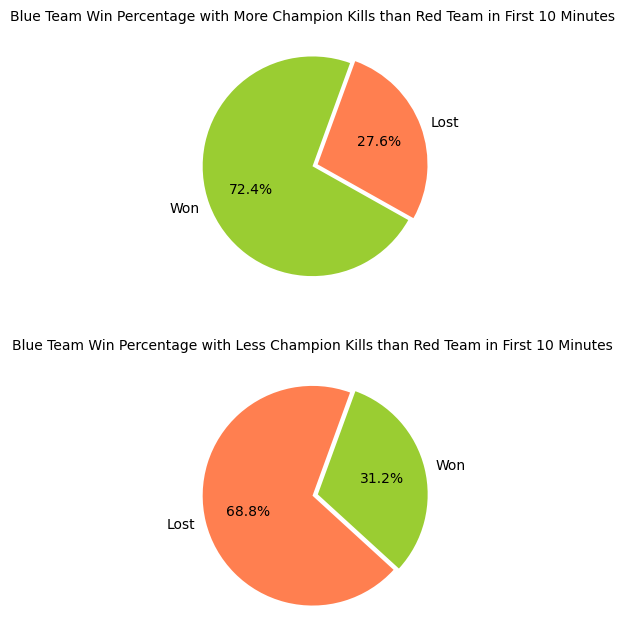

In [19]:
fig = plt.figure(figsize=(10,8), dpi=100)
ax1 = plt.subplot2grid((2,1),(0,0))
plt.pie(champkillpositive_pie, labels=champkillpositive_pie.index, explode= (0,0.05),
       colors=['YellowGreen', 'Coral'],
       autopct='%1.1f%%', startangle=70)
plt.title("Blue Team Win Percentage with More Champion Kills than Red Team in First 10 Minutes", fontsize=10, color='Black')

ax1 = plt.subplot2grid((2,1),(1,0))
plt.pie(champkillnegative_pie, labels=champkillnegative_pie.index, explode= (0,0.05),
       colors=['Coral', 'Yellowgreen'],
       autopct='%1.1f%%', startangle=70)
plt.title("Blue Team Win Percentage with Less Champion Kills than Red Team in First 10 Minutes", fontsize=10, color='Black');

In [20]:
hdr10['wardsdifference'] = hdr10["bluewardsplaced"]-hdr10["redwardsplaced"]

wardsdifferencepositive_temp = hdr10.query("wardsdifference>0")['bluewins']
wardsdifferencepositive_pie = wardsdifferencepositive_temp.value_counts()
wardsdifferencepositive_pie.rename(index={1: "Won", 0:"Lost"}, inplace=True)

wardsdifferencenegative_temp = hdr10.query("wardsdifference<=0")['bluewins']
wardsdifferencenegative_pie = wardsdifferencenegative_temp.value_counts()
wardsdifferencenegative_pie.rename(index={1: "Won", 0:"Lost"}, inplace=True)

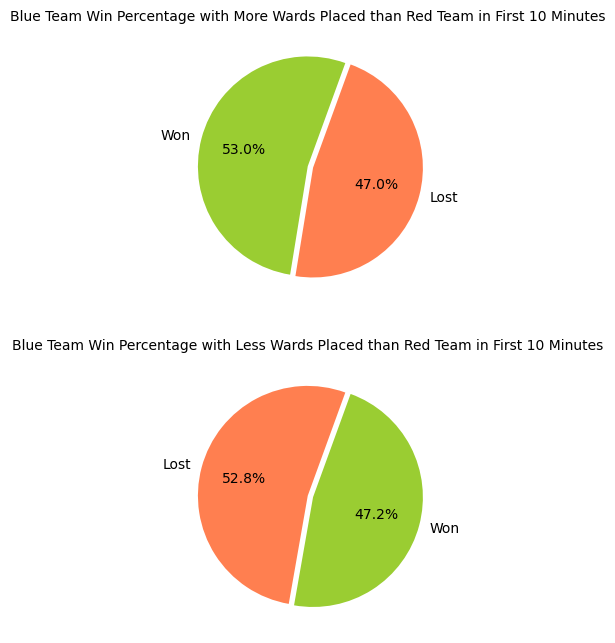

In [21]:
fig = plt.figure(figsize=(10,8), dpi=100)
ax1 = plt.subplot2grid((2,1),(0,0))
plt.pie(wardsdifferencepositive_pie, labels=wardsdifferencepositive_pie.index, explode= (0,0.05),
       colors=['YellowGreen', 'Coral'],
       autopct='%1.1f%%', startangle=70)
plt.title("Blue Team Win Percentage with More Wards Placed than Red Team in First 10 Minutes", fontsize=10, color='Black')

ax1 = plt.subplot2grid((2,1),(1,0))
plt.pie(wardsdifferencenegative_pie, labels=wardsdifferencenegative_pie.index, explode= (0,0.05),
       colors=['Coral', 'Yellowgreen'],
       autopct='%1.1f%%', startangle=70)
plt.title("Blue Team Win Percentage with Less Wards Placed than Red Team in First 10 Minutes", fontsize=10, color='Black');

In [22]:
"""#Ratio of kills to deaths 
hdr10["killtodeathratio"] = hdr10["bluekills"]/hdr10["bluedeaths"]

killdeathratioabove1_temp = hdr10.query("killtodeathratio>=1")["bluewins"] 
killdeathratioabove1_graph = killdeathratioabove1_temp.value_counts() 
killdeathratioabove1_graph.rename(index={1:"Won",0:"Lost"}, inplace=True)

killdeathratiobelow1_temp = hdr10.query("killtodeathratio<1")["bluewins"] 
killdeathratiobelow1_graph = killdeathratiobelow1_temp.value_counts() 
killdeathratiobelow1_graph.rename(index={1:"Won",0:"Lost"}, inplace=True)"""

'#Ratio of kills to deaths \nhdr10["killtodeathratio"] = hdr10["bluekills"]/hdr10["bluedeaths"]\n\nkilldeathratioabove1_temp = hdr10.query("killtodeathratio>=1")["bluewins"] \nkilldeathratioabove1_graph = killdeathratioabove1_temp.value_counts() \nkilldeathratioabove1_graph.rename(index={1:"Won",0:"Lost"}, inplace=True)\n\nkilldeathratiobelow1_temp = hdr10.query("killtodeathratio<1")["bluewins"] \nkilldeathratiobelow1_graph = killdeathratiobelow1_temp.value_counts() \nkilldeathratiobelow1_graph.rename(index={1:"Won",0:"Lost"}, inplace=True)'

In [23]:
"""fig = plt.figure(figsize=(10,8), dpi=100)
ax1 = plt.subplot2grid((2,1),(0,0))
plt.pie(killdeathratioabove1_graph, labels=killdeathratioabove1_graph.index, explode= (0,0.05),
       colors=['YellowGreen', 'Coral'],
       autopct='%1.1f%%', startangle=70)
plt.title("Blue Team Win Percentage with more kills than deaths in first 10 Minutes", fontsize=10, color='Black')

ax1 = plt.subplot2grid((2,1),(1,0))
plt.pie(killdeathratiobelow1_graph, labels=killdeathratiobelow1_graph.index, explode= (0,0.05),
       colors=['Coral', 'Yellowgreen'],
       autopct='%1.1f%%', startangle=70)
plt.title("Blue Team Win Percentage with less kills than deaths in first 10 Minutes", fontsize=10, color='Black');"""

'fig = plt.figure(figsize=(10,8), dpi=100)\nax1 = plt.subplot2grid((2,1),(0,0))\nplt.pie(killdeathratioabove1_graph, labels=killdeathratioabove1_graph.index, explode= (0,0.05),\n       colors=[\'YellowGreen\', \'Coral\'],\n       autopct=\'%1.1f%%\', startangle=70)\nplt.title("Blue Team Win Percentage with more kills than deaths in first 10 Minutes", fontsize=10, color=\'Black\')\n\nax1 = plt.subplot2grid((2,1),(1,0))\nplt.pie(killdeathratiobelow1_graph, labels=killdeathratiobelow1_graph.index, explode= (0,0.05),\n       colors=[\'Coral\', \'Yellowgreen\'],\n       autopct=\'%1.1f%%\', startangle=70)\nplt.title("Blue Team Win Percentage with less kills than deaths in first 10 Minutes", fontsize=10, color=\'Black\');'

## Scaling and Feature Selection

In [24]:
hdr10_scaled = hdr10.copy()

# Create the scaler with object range of 0-1
scaler = MinMaxScaler()

# Fit and transform using the training data
hdr10_scaled[hdr10_scaled.columns] = scaler.fit_transform(hdr10[hdr10.columns])

In [25]:
hdr10_scaled.head()

,bluewins,bluewardsplaced,bluewardsdestroyed,bluefirstblood,bluekills,bluedeaths,blueassists,blueelitemonsters,bluedragons,blueheralds,...,redtotalexperience,redtotalminionskilled,redtotaljungleminionskilled,redgolddiff,redexperiencediff,redcspermin,redgoldpermin,minionskilldifference,championkilldifference,wardsdifference
gameid,,,,,,,,,,,,,,,,,,,,,
4519157822,0.0,0.093878,0.074074,1.0,0.409091,0.272727,0.379310,0.0,0.0,0.0,...,0.557608,0.494505,0.579545,0.485446,0.472598,0.494505,0.464844,0.477733,0.606061,0.552632
4523371949,0.0,0.028571,0.037037,0.0,0.227273,0.227273,0.172414,0.0,0.0,0.0,...,0.590732,0.730769,0.545455,0.644706,0.538488,0.730769,0.556250,0.218623,0.515152,0.526316
4521474530,0.0,0.040816,0.000000,0.0,0.318182,0.500000,0.137931,0.5,1.0,0.0,...,0.575144,0.527473,0.272727,0.566848,0.530570,0.527473,0.527170,0.417004,0.393939,0.526316
4524384067,0.0,0.155102,0.037037,0.0,0.181818,0.227273,0.172414,0.5,0.0,1.0,...,0.635039,0.703297,0.488636,0.573530,0.472541,0.703297,0.457118,0.348178,0.484848,0.582996
4436033771,0.0,0.285714,0.148148,0.0,0.272727,0.272727,0.206897,0.0,0.0,0.0,...,0.664859,0.648352,0.715909,0.559313,0.459137,0.648352,0.537500,0.425101,0.515152,0.643725


In [26]:
features=hdr10_scaled.columns[1:]
features

Index(['bluewardsplaced', 'bluewardsdestroyed', 'bluefirstblood', 'bluekills',
       'bluedeaths', 'blueassists', 'blueelitemonsters', 'bluedragons',
       'blueheralds', 'bluetowersdestroyed', 'bluetotalgold', 'blueavglevel',
       'bluetotalexperience', 'bluetotalminionskilled',
       'bluetotaljungleminionskilled', 'bluegolddiff', 'blueexperiencediff',
       'bluecspermin', 'bluegoldpermin', 'redwardsplaced', 'redwardsdestroyed',
       'redfirstblood', 'redkills', 'reddeaths', 'redassists',
       'redelitemonsters', 'reddragons', 'redheralds', 'redtowersdestroyed',
       'redtotalgold', 'redavglevel', 'redtotalexperience',
       'redtotalminionskilled', 'redtotaljungleminionskilled', 'redgolddiff',
       'redexperiencediff', 'redcspermin', 'redgoldpermin',
       'minionskilldifference', 'championkilldifference', 'wardsdifference'],
      dtype='object')

In [27]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(hdr10_scaled[features], 
                                                              hdr10_scaled["bluewins"], 
                                                              test_size=0.2, 
                                                              random_state=20)
# Perform the second split
X_train, X_valid, y_train, y_valid = train_test_split(X_train_temp, y_train_temp, 
                                                      test_size=0.25, random_state=20)

#### Feature selection using lasso regression

Text(0, 0.5, 'Coefficients')

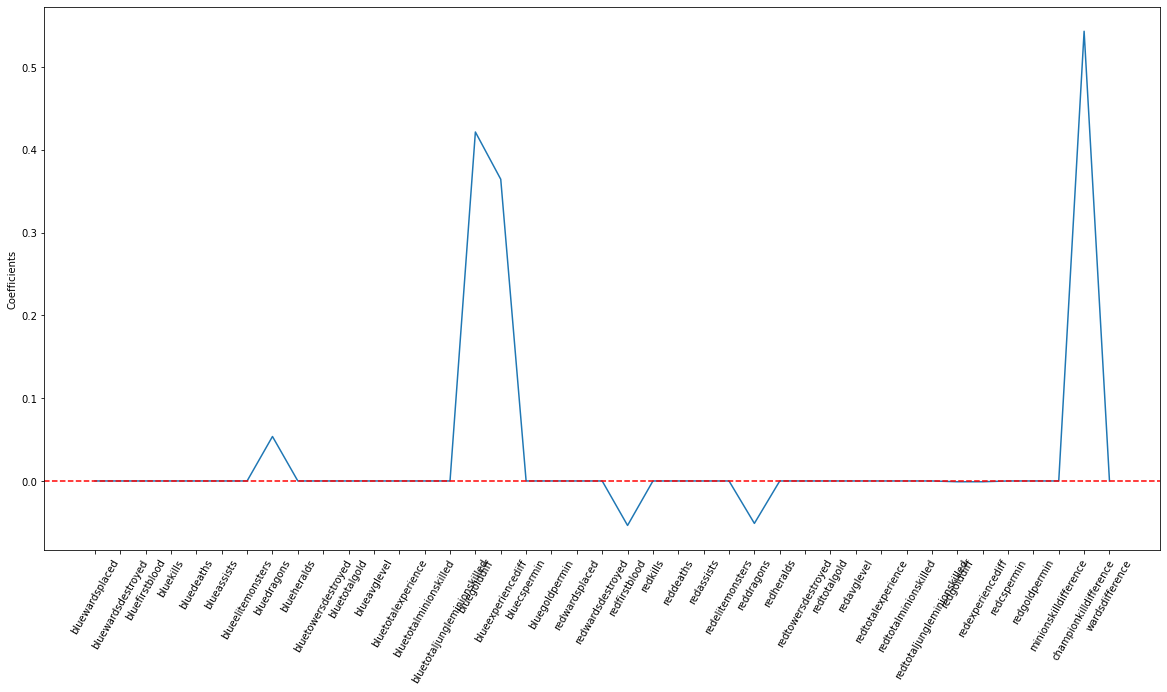

In [28]:
# Create the model
lasso = Lasso(alpha=0.01)

# Fit the model to the training data
lasso.fit(X_train, y_train)

# Extract the coefficients
lasso_coef = lasso.coef_

# Plot the coefficients
plt.figure(figsize=(20, 10))
plt.plot(range(len(X_train.columns)), lasso_coef)
plt.xticks(range(len(X_train.columns)), X_train.columns, rotation=60)
plt.axhline(0.0, linestyle='--', color='r')
plt.ylabel('Coefficients')

In [29]:
temp = pd.DataFrame(X_train.columns.values, lasso_coef)
temp.reset_index(inplace=True)
temp.columns=['lasso_coef','features']
print(temp[temp['lasso_coef']!=0])

lasso_selected_features = temp[temp['lasso_coef']!=0]['features']
lasso_selected_features

    lasso_coef                features
7     0.053716             bluedragons
15    0.421491            bluegolddiff
16    0.364399      blueexperiencediff
21   -0.053715           redfirstblood
26   -0.051248              reddragons
34   -0.000938             redgolddiff
35   -0.000946       redexperiencediff
39    0.543153  championkilldifference


7                bluedragons
15              bluegolddiff
16        blueexperiencediff
21             redfirstblood
26                reddragons
34               redgolddiff
35         redexperiencediff
39    championkilldifference
Name: features, dtype: object

In [30]:
#Dataset with features selected by Lasso
lasso_Xtrain = X_train.loc[:,lasso_selected_features]
lasso_Xvalid = X_valid.loc[:,lasso_selected_features]
lasso_Xtest = X_test.loc[:,lasso_selected_features]

In [31]:
# Feature selection based on SelectKBest
select_k_best_classifier = SelectKBest(score_func=mutual_info_classif, k=8)
select_k_best_classifier.fit_transform(X_train, y_train)
mask = select_k_best_classifier.get_support()

kbest_selected_features = X_train.columns[mask]
kbest_selected_features

Index(['bluetotalgold', 'bluegolddiff', 'blueexperiencediff', 'bluegoldpermin',
       'redtotalexperience', 'redgolddiff', 'redexperiencediff',
       'championkilldifference'],
      dtype='object')

In [32]:
#Dataset with features selected by Kbest
kbest_Xtrain = X_train.loc[:,kbest_selected_features]
kbest_Xvalid = X_valid.loc[:,kbest_selected_features]
kbest_Xtest = X_test.loc[:,kbest_selected_features]

## Logistic Regression

In [33]:
#Training logistic regression model on features selected by lasso
lasso_lr= LogisticRegression()
lasso_lr.fit(lasso_Xtrain,y_train)
lasso_ypred=lasso_lr.predict(lasso_Xvalid)

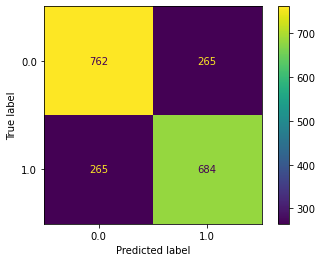

In [34]:
 plot_confusion_matrix(lasso_lr, lasso_Xvalid, y_valid) 

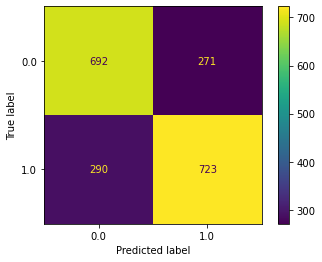

In [35]:
plot_confusion_matrix(lasso_lr, lasso_Xtest, y_test) 

In [36]:
#checking accuracy of regression model on validation data set with features selected by lasso 
print('Accuracy based on Lasso Features: ',metrics.accuracy_score(y_valid, lasso_ypred))
plt.show()

Accuracy based on Lasso Features:  0.7317813765182186


In [37]:
#Training logistic regression model on test data set to check the accuracy
lasso_lr= LogisticRegression()
lasso_lr.fit(lasso_Xtrain,y_train)
lasso_ypredtest=lasso_lr.predict(lasso_Xtest)

In [38]:
print('Accuracy based on Lasso Features :',metrics.accuracy_score(y_test,lasso_ypredtest))

Accuracy based on Lasso Features : 0.7160931174089069


In [39]:
#Training logistic regression model on validation dataset with features from kbest
kbest_lr= LogisticRegression()
kbest_lr.fit(kbest_Xtrain,y_train)
kbest_ypred=kbest_lr.predict(kbest_Xvalid)

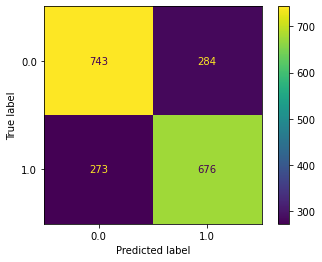

In [40]:
 plot_confusion_matrix(kbest_lr, kbest_Xvalid, y_valid) 

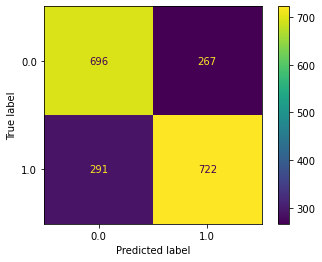

In [41]:
plot_confusion_matrix(kbest_lr, kbest_Xtest, y_test) 

In [42]:
#checking accuracy of regression model with features selected by kbest 
print('Accuracy: ',metrics.accuracy_score(y_valid, kbest_ypred))
plt.show()

Accuracy:  0.7181174089068826


In [43]:
#Training logistic regression model on test dataset with features from kbest
kbest_lr= LogisticRegression()
kbest_lr.fit(kbest_Xtrain,y_train)
kbest_ypredtest=kbest_lr.predict(kbest_Xtest)

In [44]:
print('Accuracy: ',metrics.accuracy_score(y_test,kbest_ypredtest))

Accuracy:  0.7176113360323887
